In [1]:
# Main library: https://square.github.io/pysurvival/index.html
#----------------------------Reproducible------------------------------------------
import numpy as np
import random as rn
import pandas as pd
import gc
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
rn.seed(seed)

#----------------------------Reproducible------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import display_loss_values
from pysurvival.utils.display import compare_to_actual

from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

import heapq
import seaborn as sns

In [2]:
def csv_read(p_path):
    pd_data=pd.read_csv(p_path, sep=',')
    column_names=pd_data.columns.values.tolist()
    print(column_names)
    return pd_data,column_names

def write_to_csv(p_data,p_path):
    dataframe = pd.DataFrame(p_data)
    dataframe.to_csv(p_path, mode='a',header=False,index=False,sep=',')
    del dataframe
    gc.collect()

In [3]:
data,column_names=csv_read('./data/survival_data_filtered_3.csv')

['NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'NACCFADM', 'NACCFFTD', 'MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE', 'CDRSUM', 'DECSUB', 'DECIN', 'COGMEM', 'COGJUDG', 'COGLANG', 'COGVIS', 'COGATTN', 'COGOTHR', 'NACCCOGF', 'COGMODE', 'DECAGE', 'BEAPATHY', 'BEDEP', 'BEVHALL', 'BEAHALL', 'BEDEL', 'BEDISIN', 'BEIRRIT', 'BEAGIT', 'BEPERCH', 'BEOTHR', 'NACCBEHF', 'BEMODE', 'MOGAIT', 'MOFALLS', 'MOTREM', 'MOSLOW', 'NACCMOTF', 'MOMODE', 'COURSE', 'FRSTCHG', 'NORMCOG', 'DEMENTED', 'NACCPPA', 'NACCBVFT', 'NACCLBDS', 'NACCTMCI', 'NACCMCIL', 'NACCMCIA', 'NACCMCIE', 'NACCMCIV', 'NACCMCII', 'IMPNOMCI', 'NACCALZD', 'NACCALZP', 'NACCLBDE', 'NACCLBDP', 'PARK', 'PSP', 'PSPIF', 'CORT', 'CORTIF', 'DOWNS', 'DOWNSIF', 'HUNT', 'HUNTIF', 'PRION', 'PRIONIF', 'BRNINJ', 'BRNINJIF', 'HYCEPH', 'HYCEPHIF', 'NEOP', 'NEOPIF', 'DEP', 'DEPIF', 'OTHPSY', 'OTHPSYIF',

In [4]:
data

,NACCREAS,NACCREFR,BIRTHMO,BIRTHYR,SEX,HISPANIC,HISPOR,RACE,RACESEC,RACETER,...,NPBNKB,NACCFORM,NACCPARA,NACCCSFP,NPBNKF,NPFAUT,NACCDAGE,NACCINT,SurvivalTime,Event
0,1,8,4,1921,2,0,88,1,88,88,...,1,1,1,1,0,0,98,4,2604,False
1,1,1,3,1923,1,0,88,1,88,88,...,1,1,1,0,0,0,92,6,3000,False
2,1,8,5,1931,1,0,88,1,88,88,...,0,1,1,0,0,0,88,43,870,True
3,1,1,8,1916,2,0,88,2,3,88,...,0,1,1,0,0,0,103,34,3698,False
4,1,8,10,1942,2,0,88,1,88,88,...,0,1,1,1,0,0,76,53,720,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,1,8,8,1925,1,0,88,1,88,88,...,0,0,1,0,0,1,92,71,1438,True
332,2,8,4,1924,1,0,88,1,88,88,...,1,0,1,0,0,0,90,15,2489,True
333,1,8,6,1941,1,0,88,1,88,88,...,1,1,1,0,0,0,76,8,437,True
334,1,1,11,1938,2,0,88,1,88,88,...,1,1,1,0,0,0,76,2,1592,True


In [5]:
Events=np.array(data.loc[:,'Event'])
print("%.2f%% samples are right censored in whole data." % (np.sum(~Events) * 100. / len(Events)))

37.20% samples are right censored in whole data.


In [ ]:
X=data.loc[:,'NACCREAS':'NACCINT']
y_=data.loc[:,'SurvivalTime':'Event']
y=np.array([(y__[1],y__[0]) for y__ in np.array(y_)], dtype=[('Event', 'bool'), ('SurvivalTime', '<f8')])

models=[]
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]
seed_num=10
epoch_num=2000

for seed_i in np.arange(seed_num):

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=seed_i)

    time_train=y_train['SurvivalTime']
    event_train=y_train['Event']
    time_test=y_test['SurvivalTime']
    event_test=y_test['Event']

    # Building the model
    nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
    nonlinear_coxph.fit(X_train, time_train, event_train, num_epochs = epoch_num,lr=1e-4, init_method='glorot_uniform')

    models.append(nonlinear_coxph)

% Completion: 100%|***********************************************|Loss: 486.38
% Completion: 100%|***********************************************|Loss: 501.68
% Completion: 100%|***********************************************|Loss: 497.62
% Completion: 100%|***********************************************|Loss: 454.23
% Completion: 100%|***********************************************|Loss: 517.70


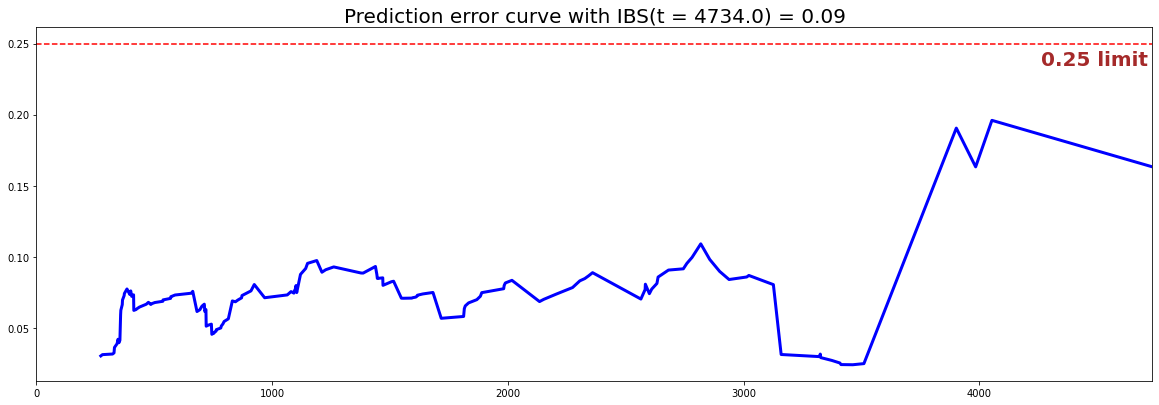

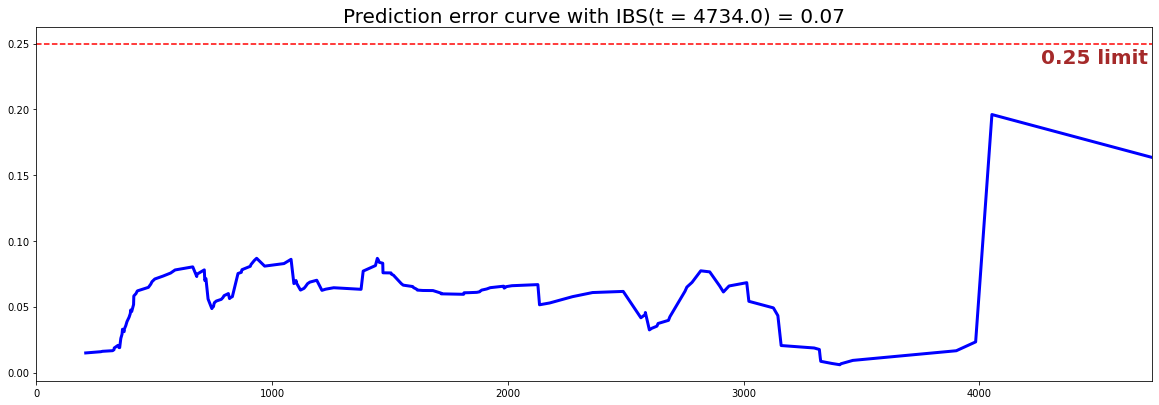

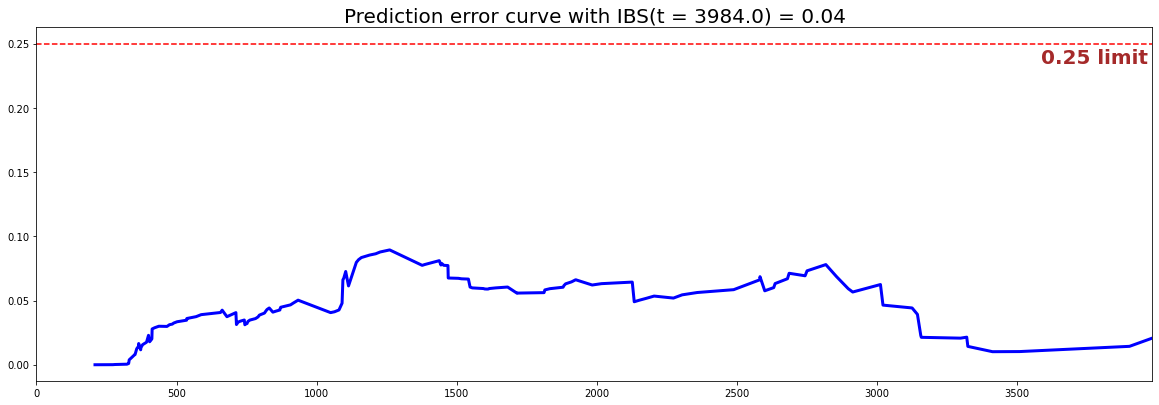

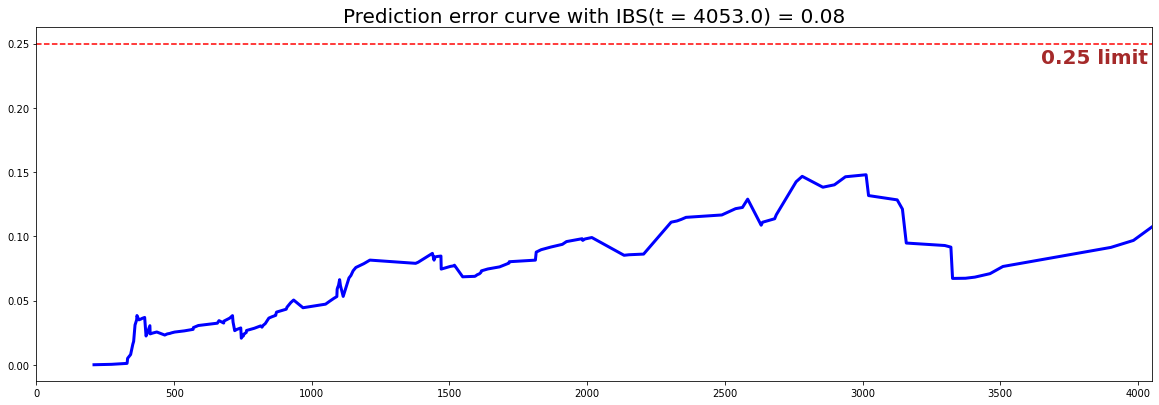

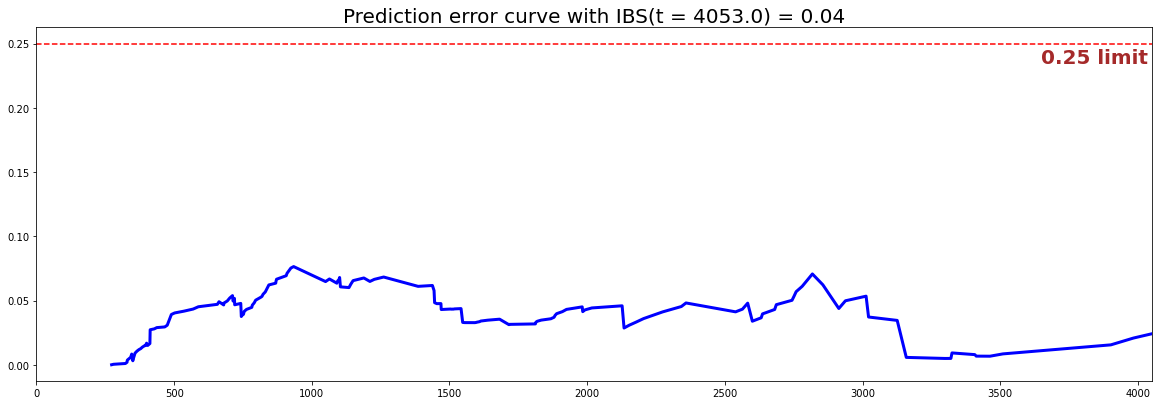

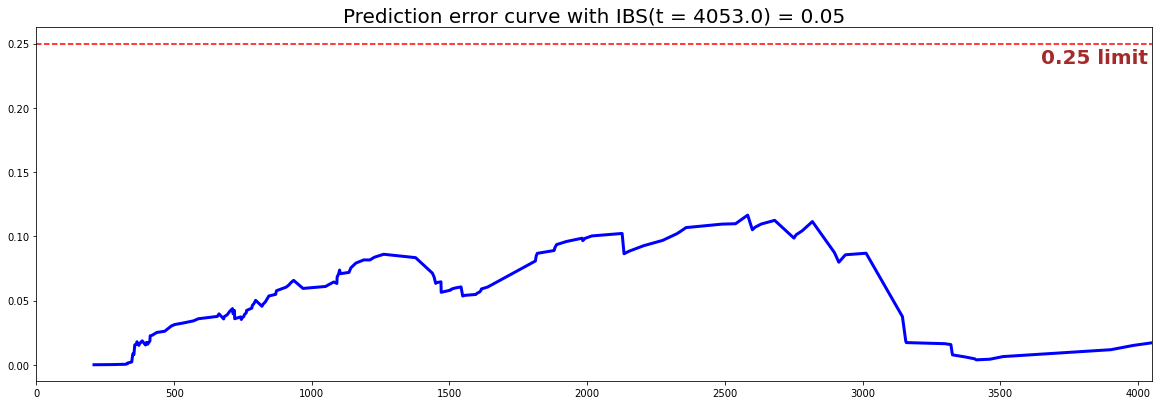

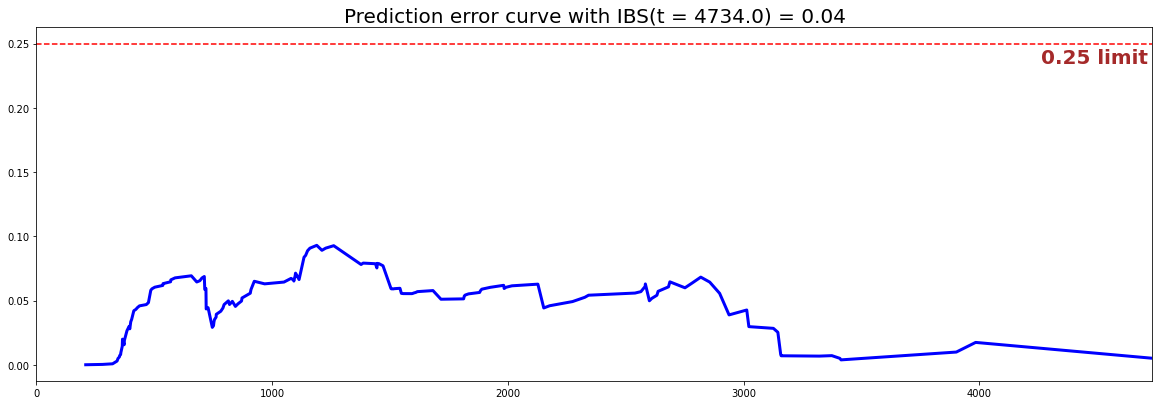

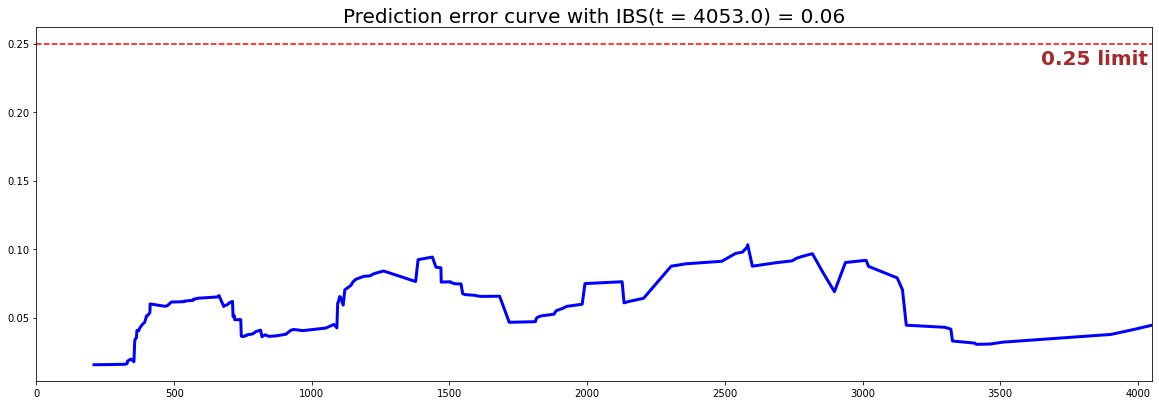

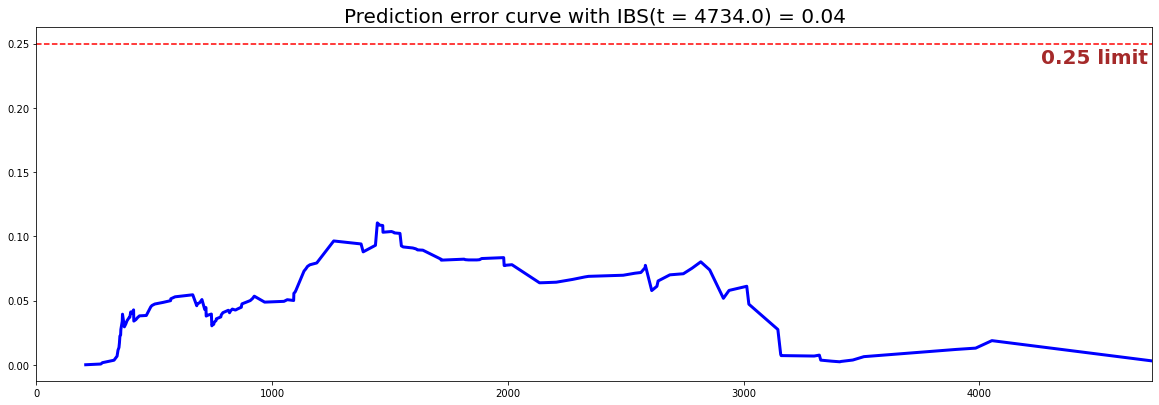

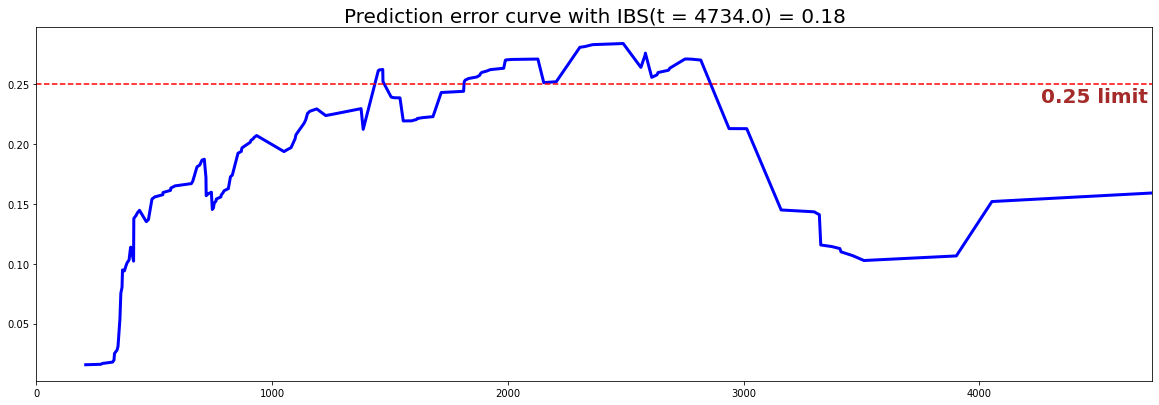

In [7]:
Loss_list=[]
C_index_list=[]
IBS_list=[]

for seed_i in np.arange(seed_num):
    model_used=models[seed_i]
    Loss_list.append(model_used.loss_values)
    
    # Model Performances
    c_index = concordance_index(model_used, X_test, time_test, event_test) #0.81
    #print('C-index: {:.2f}'.format(c_index))

    ibs = integrated_brier_score(model_used, X_test, time_test, event_test, t_max=None, figure_size=(20, 6.5) )
    #print('IBS: {:.2f}'.format(ibs))

    C_index_list.append(c_index)
    IBS_list.append(ibs)

In [8]:
p_path="./performance_CI.csv"
write_to_csv(np.array(C_index_list).reshape(1,np.array(C_index_list).shape[0]),p_path)
print(C_index_list)
print(np.mean(C_index_list))
print(np.std(C_index_list))

p_path="./performance_IBS.csv"
write_to_csv(np.array(IBS_list).reshape(1,np.array(IBS_list).shape[0]),p_path)
print(IBS_list)
print(np.mean(IBS_list))
print(np.std(IBS_list))

[0.895534272596443, 0.9183063490941813, 0.9322268117925747, 0.8842917842814871, 0.9499443816026388, 0.9226331017352549, 0.9357028173459488, 0.9018500817287636, 0.9222199111425541, 0.7272678523979432]
0.8989977363717789
0.06020404225385631
[0.08927417841792075, 0.06806433518457815, 0.042950145687227485, 0.07706066254606218, 0.03507537330815966, 0.05468725821528432, 0.03744498376501837, 0.05717155102289874, 0.042896320139191195, 0.17858506261532384]
0.06832098709016646
0.04041352566072405


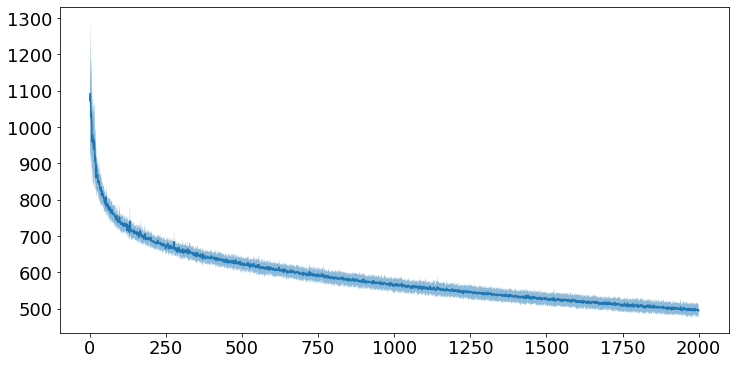

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
Loss_list_mean=np.mean(np.array(Loss_list),axis=0)
Loss_list_std=np.std(np.array(Loss_list),axis=0)

max_loss=int(np.max(Loss_list_mean))+1
min_loss=int(np.min(Loss_list_mean))
step=int(max_loss/5)

ax.plot(np.arange(epoch_num)+1, Loss_list_mean, '-')
ax.fill_between(np.arange(epoch_num)+1, Loss_list_mean - Loss_list_std, Loss_list_mean + Loss_list_std, alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

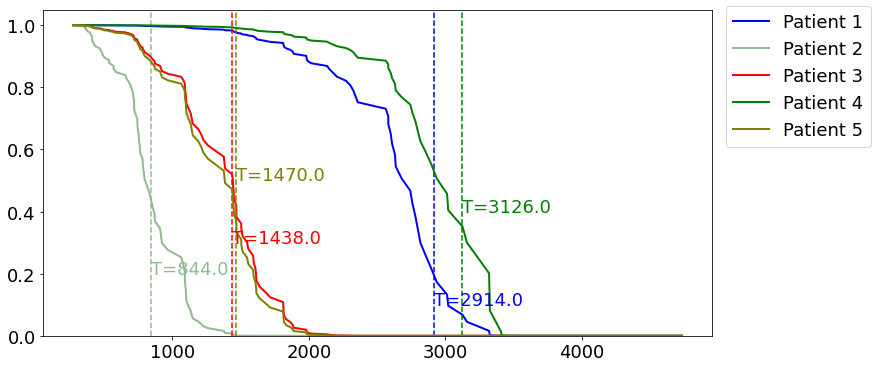

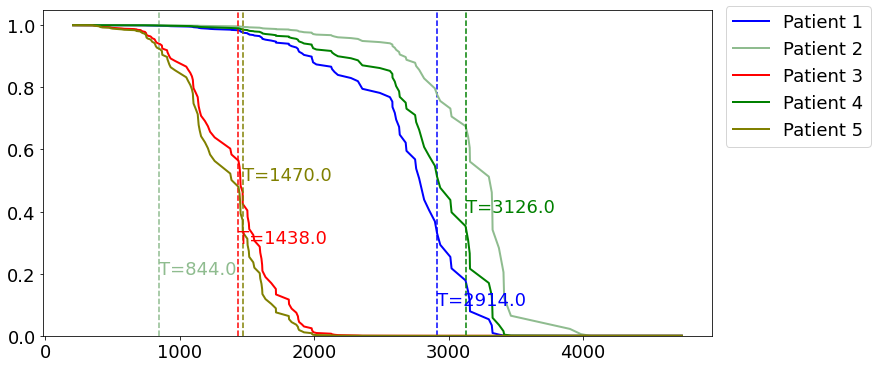

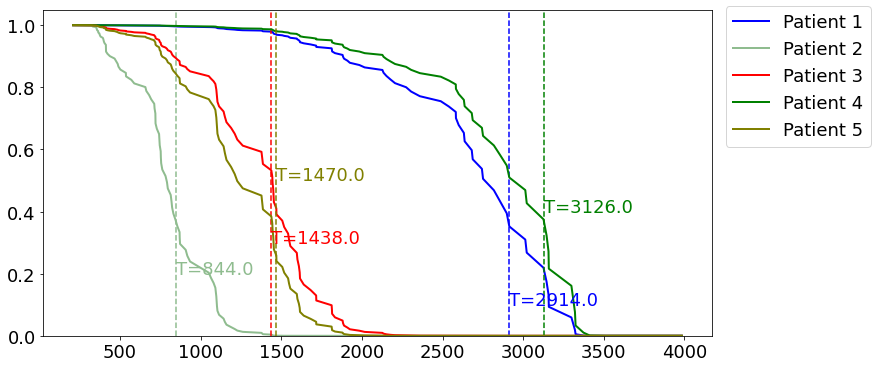

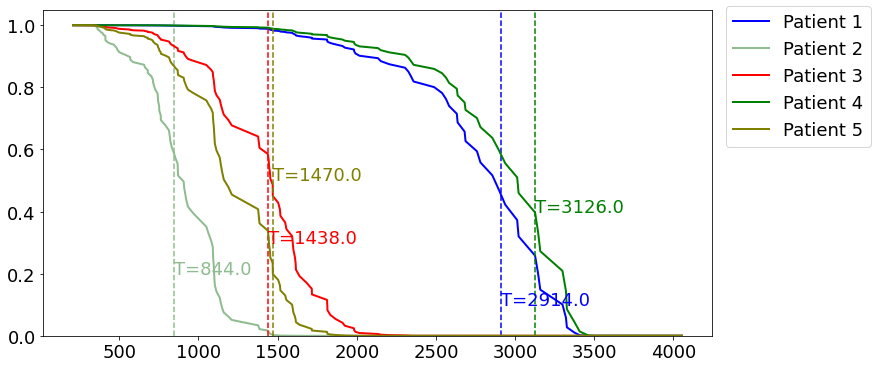

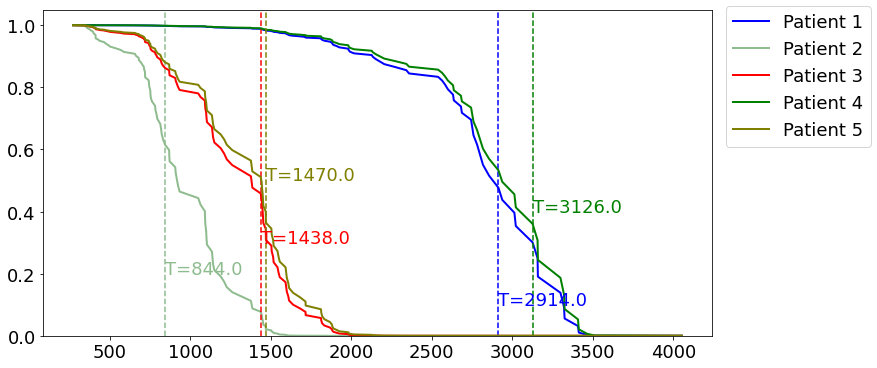

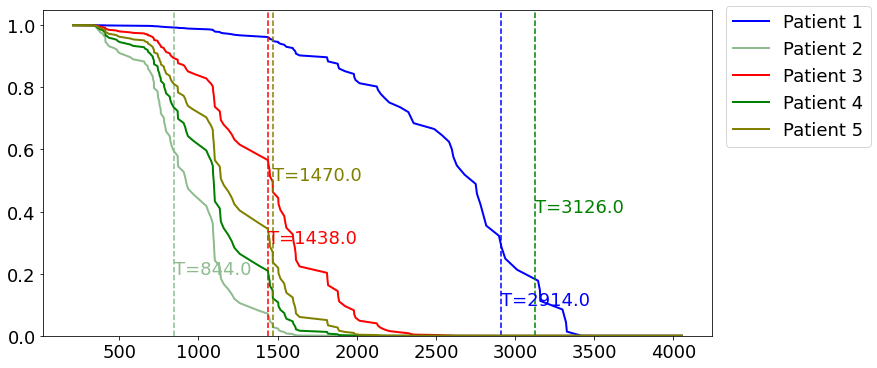

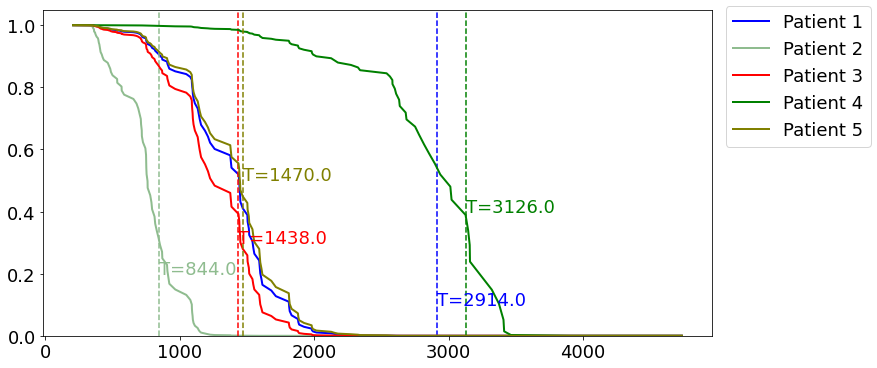

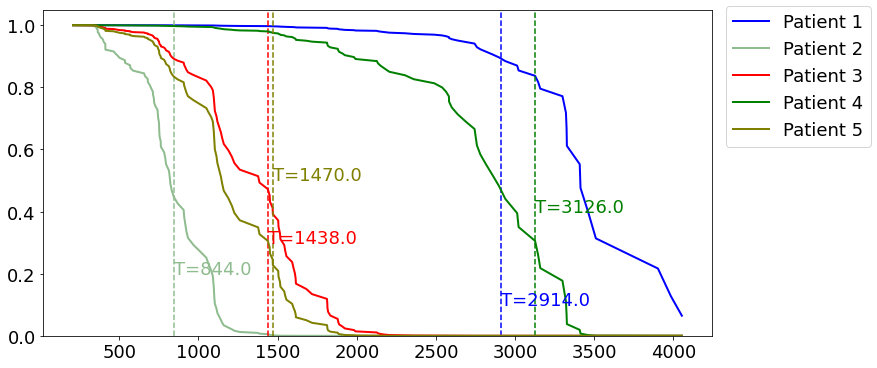

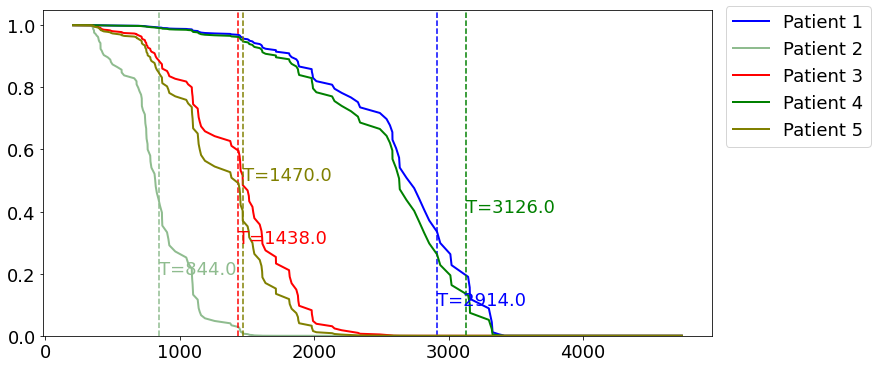

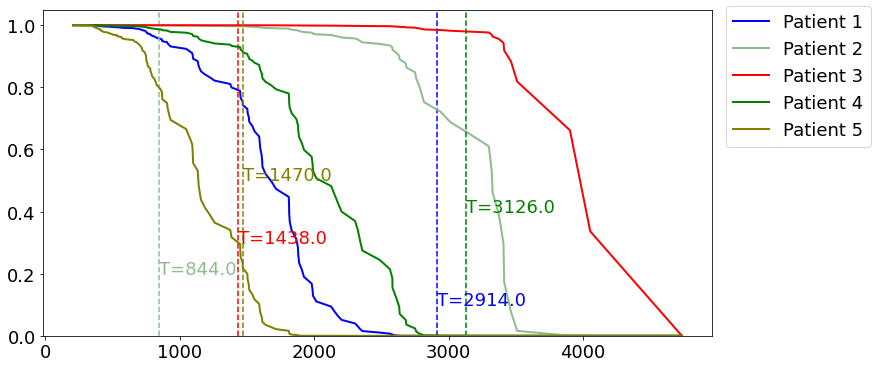

In [10]:
cs=['blue','darkseagreen','red','green','olive','cyan','tan','silver','purple','fuchsia','chocolate','darkcyan','aqua','pink','orange','bisque','lightsteelblue']

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 5,replace=False)

for seed_i in np.arange(seed_num):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Saving the time of event
    for i in np.arange(len(k_list)):
        k=k_list[i]
        t = time_test[k]

        # Computing the Survival function for all times t
        predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

        # Displaying the functions
        plt.plot(models[seed_i].times, predicted, color=cs[i], label='Patient '+str(i+1), lw=2)
    
        # Actual time
        plt.axvline(x=t, color=cs[i], ls ='--')
        ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, (0.1+i/10)), fontsize=18,color=cs[i])

    plt.legend(loc=[1.02,0.58],fontsize=18, ncol=1)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

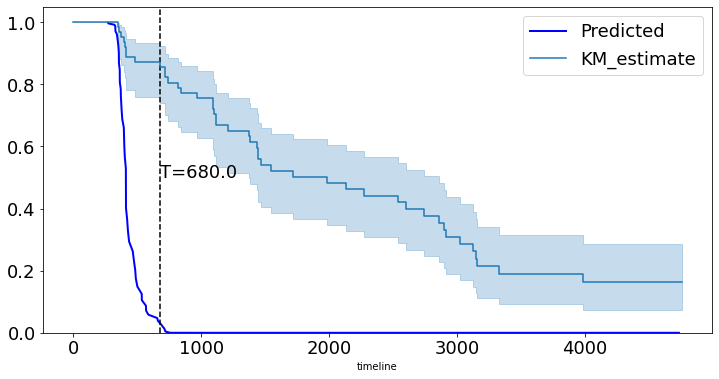

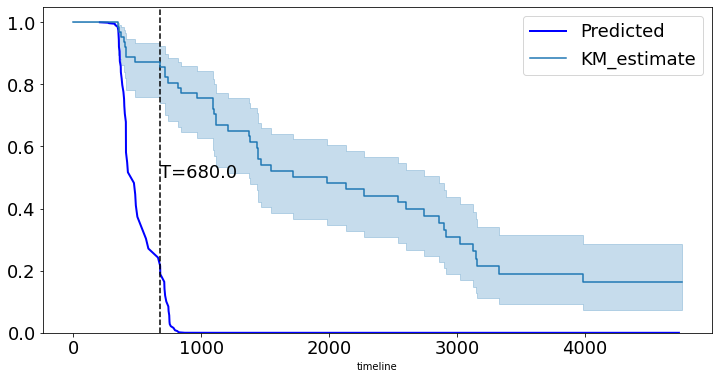

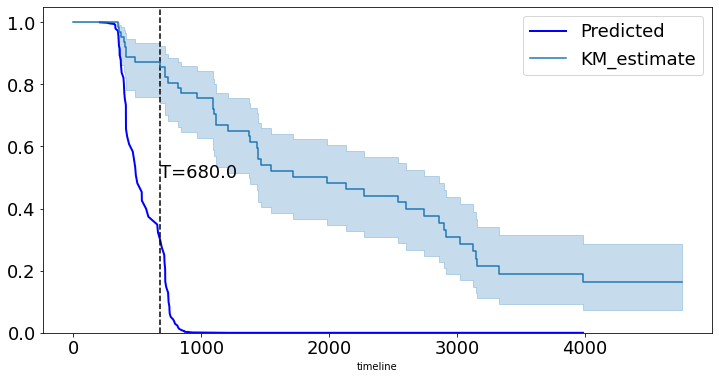

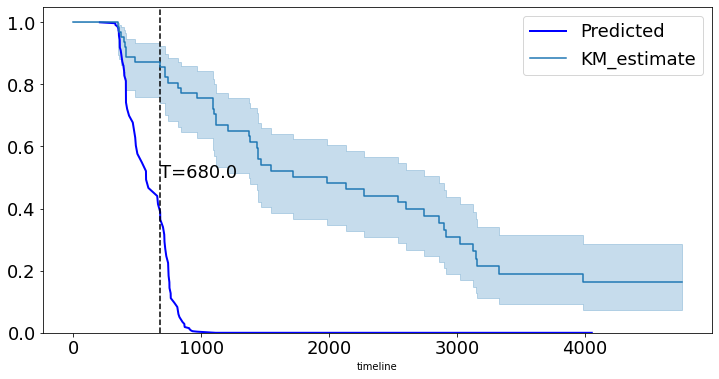

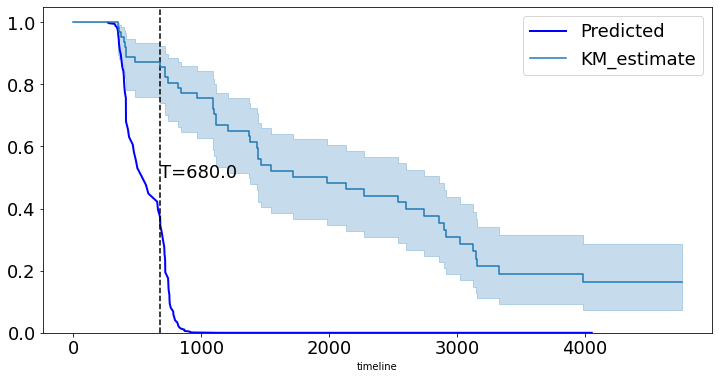

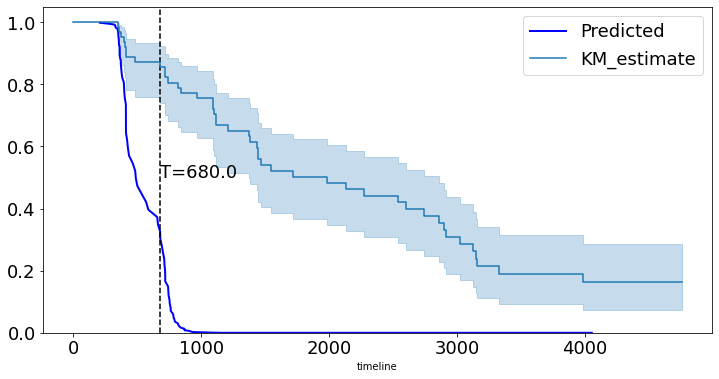

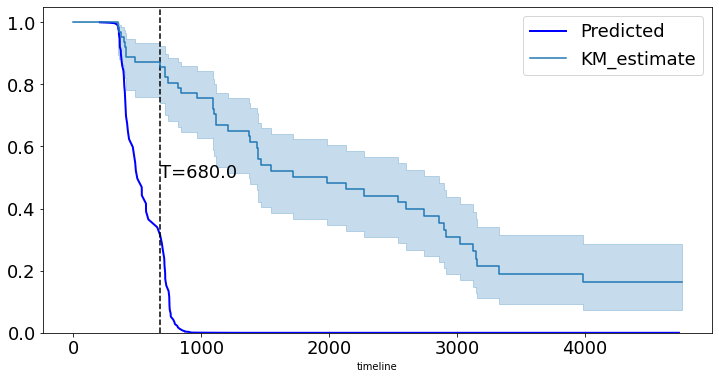

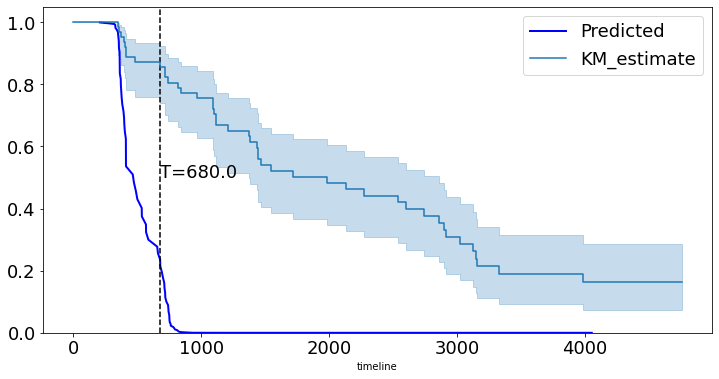

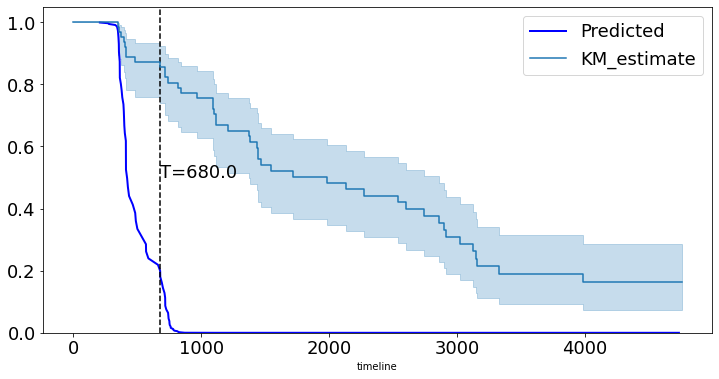

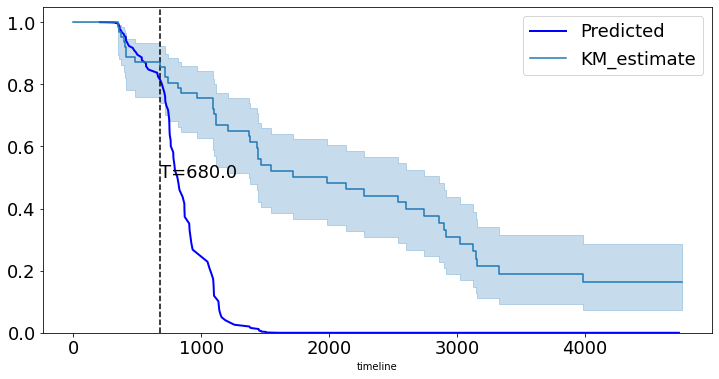

In [11]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice( choices, 1)[0]
    
for seed_i in np.arange(seed_num):
    
    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(12, 6))

    # Saving the time of event
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(models[seed_i].times, predicted, color='blue', label='Predicted', lw=2)

    # Actual time
    plt.axvline(x=t, color='black', ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

    kmf.fit(time_test, event_observed=event_test)
    ax = kmf.plot_survival_function(ax=ax)

    # Show everything
    plt.legend(fontsize=18)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [12]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice(choices, 1)[0]

# Saving the time of event
t = time_test[k]

predicted_list=[]
time_set={'Nan'}

for seed_i in np.arange(seed_num):
    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()
    time=models[seed_i].times

    predicted_list.append(dict(zip(time,predicted)))
    time_set.update(set(time))

average_time_predicted_dict={}
for time_set_i in time_set:
    predicted_value=[]
    for seed_i in np.arange(seed_num):
        if time_set_i in predicted_list[seed_i].keys():
            predicted_value.append(predicted_list[seed_i][time_set_i])
    if len(predicted_value)>0:
        average_time_predicted_dict[time_set_i]=[np.mean(predicted_value),np.std(predicted_value)]
        
average_time_predicted={}
for i in sorted (average_time_predicted_dict.keys()) : 
    average_time_predicted[i]=average_time_predicted_dict[i]

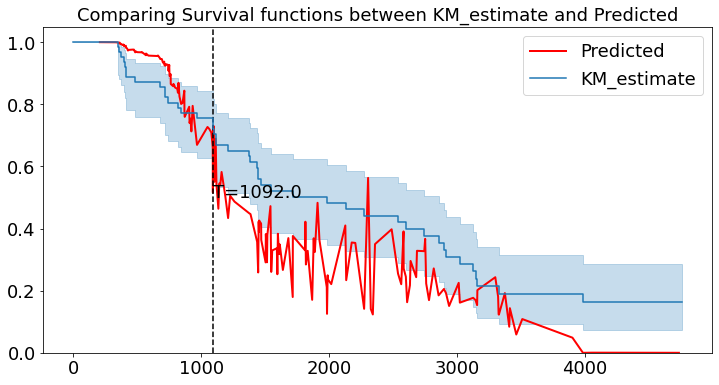

In [13]:
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(12, 6))

# Displaying the functions
plt.plot(list(average_time_predicted.keys()), np.array(list(average_time_predicted.values()))[:,0], color='red', label='Predicted', lw=2)

# Actual time
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

kmf.fit(time_test, event_observed=event_test)
ax = kmf.plot_survival_function(ax=ax)

# Show everything
title = "Comparing Survival functions between KM_estimate and Predicted"
plt.legend(fontsize=18)
plt.title(title, fontsize=18)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("",fontsize=18)
plt.show()

In [14]:
models[0].model

NeuralNet(
  (model): Sequential(
    (0): Linear(in_features=243, out_features=150, bias=True)
    (1): BentIdentity()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=150, out_features=1, bias=True)
  )
)

In [15]:
feature_importace_list=[]
first_layer_weight_list=[]
for seed_i in np.arange(seed_num):
    first_layer_weight_=np.array(np.transpose(models[seed_i].model.state_dict()['model.0.weight']))
    feature_importace_=np.linalg.norm(first_layer_weight_,1, axis=1)
    first_layer_weight_list.append(first_layer_weight_)
    feature_importace_list.append(feature_importace_)

In [16]:
feature_importace=np.mean(np.array(feature_importace_list),axis=0)

In [17]:
column_names

['NACCREAS',
 'NACCREFR',
 'BIRTHMO',
 'BIRTHYR',
 'SEX',
 'HISPANIC',
 'HISPOR',
 'RACE',
 'RACESEC',
 'RACETER',
 'PRIMLANG',
 'EDUC',
 'MARISTAT',
 'NACCLIVS',
 'INDEPEND',
 'RESIDENC',
 'HANDED',
 'NACCFADM',
 'NACCFFTD',
 'MEMORY',
 'ORIENT',
 'JUDGMENT',
 'COMMUN',
 'HOMEHOBB',
 'PERSCARE',
 'CDRSUM',
 'DECSUB',
 'DECIN',
 'COGMEM',
 'COGJUDG',
 'COGLANG',
 'COGVIS',
 'COGATTN',
 'COGOTHR',
 'NACCCOGF',
 'COGMODE',
 'DECAGE',
 'BEAPATHY',
 'BEDEP',
 'BEVHALL',
 'BEAHALL',
 'BEDEL',
 'BEDISIN',
 'BEIRRIT',
 'BEAGIT',
 'BEPERCH',
 'BEOTHR',
 'NACCBEHF',
 'BEMODE',
 'MOGAIT',
 'MOFALLS',
 'MOTREM',
 'MOSLOW',
 'NACCMOTF',
 'MOMODE',
 'COURSE',
 'FRSTCHG',
 'NORMCOG',
 'DEMENTED',
 'NACCPPA',
 'NACCBVFT',
 'NACCLBDS',
 'NACCTMCI',
 'NACCMCIL',
 'NACCMCIA',
 'NACCMCIE',
 'NACCMCIV',
 'NACCMCII',
 'IMPNOMCI',
 'NACCALZD',
 'NACCALZP',
 'NACCLBDE',
 'NACCLBDP',
 'PARK',
 'PSP',
 'PSPIF',
 'CORT',
 'CORTIF',
 'DOWNS',
 'DOWNSIF',
 'HUNT',
 'HUNTIF',
 'PRION',
 'PRIONIF',
 'BRNINJ',
 'BRN

In [18]:
k=100
p_path="./feature_selection.csv"

top_k=heapq.nlargest(k, range(len(feature_importace)), feature_importace.take)

In [19]:
write_to_csv(np.array(top_k).reshape(1,np.array(top_k).shape[0]),p_path)

top_k

[109,
 220,
 105,
 108,
 9,
 27,
 22,
 59,
 20,
 12,
 175,
 67,
 136,
 0,
 241,
 230,
 150,
 131,
 73,
 174,
 29,
 43,
 215,
 21,
 235,
 121,
 234,
 126,
 190,
 54,
 103,
 68,
 123,
 192,
 124,
 23,
 25,
 113,
 10,
 102,
 8,
 134,
 166,
 41,
 13,
 122,
 69,
 216,
 212,
 140,
 49,
 51,
 48,
 24,
 61,
 37,
 188,
 4,
 31,
 28,
 231,
 83,
 129,
 44,
 36,
 100,
 111,
 157,
 45,
 50,
 91,
 62,
 11,
 112,
 138,
 34,
 16,
 238,
 39,
 81,
 94,
 142,
 137,
 133,
 219,
 15,
 30,
 233,
 110,
 57,
 125,
 96,
 146,
 1,
 135,
 66,
 182,
 187,
 38,
 214]

In [20]:
write_to_csv(feature_importace[top_k].reshape(1,feature_importace[top_k].shape[0]),p_path)

feature_importace[top_k]

array([15.969513 , 12.713016 , 12.665043 , 11.866524 , 11.564769 ,
       11.54995  , 11.147136 , 10.7118435, 10.256561 , 10.208487 ,
       10.194527 , 10.141828 , 10.096624 , 10.079517 , 10.008336 ,
        9.932781 ,  9.91577  ,  9.906691 ,  9.904311 ,  9.901053 ,
        9.900656 ,  9.870128 ,  9.851542 ,  9.845649 ,  9.818121 ,
        9.812884 ,  9.812336 ,  9.810292 ,  9.807469 ,  9.794188 ,
        9.778522 ,  9.778255 ,  9.7729225,  9.768696 ,  9.764088 ,
        9.749873 ,  9.728013 ,  9.714719 ,  9.711126 ,  9.705345 ,
        9.652855 ,  9.63307  ,  9.604946 ,  9.595813 ,  9.586551 ,
        9.5843525,  9.5689745,  9.5636015,  9.551105 ,  9.548187 ,
        9.509318 ,  9.509219 ,  9.505739 ,  9.501333 ,  9.49918  ,
        9.488929 ,  9.487078 ,  9.483797 ,  9.483561 ,  9.475317 ,
        9.471518 ,  9.469271 ,  9.468918 ,  9.467674 ,  9.458639 ,
        9.453303 ,  9.453179 ,  9.443408 ,  9.438479 ,  9.437578 ,
        9.43732  ,  9.433263 ,  9.433137 ,  9.430204 ,  9.4240

In [21]:
write_to_csv(np.array(column_names[:-2])[top_k].reshape(1,np.array(column_names[:-2])[top_k].shape[0]),p_path)

np.array(column_names[:-2])[top_k]

array(['NACCAGE', 'NPPDXE', 'NACCAGEB', 'NACCIDEM', 'RACETER', 'DECIN',
       'COMMUN', 'NACCPPA', 'ORIENT', 'MARISTAT', 'NPWMR', 'NACCMCII',
       'NPADNC', 'NACCREAS', 'NACCDAGE', 'NACCDOWN', 'NPINF3B', 'NPHIST',
       'PARK', 'NACCARTE', 'COGJUDG', 'BEIRRIT', 'NPTDPE', 'JUDGMENT',
       'NPBNKB', 'NPGRSNH', 'NACCBNKF', 'NPASAN', 'NPNLOSS', 'MOMODE',
       'NACCADMU', 'IMPNOMCI', 'NACCAVAS', 'NPFTDTAU', 'NPTAN',
       'HOMEHOBB', 'CDRSUM', 'NPPMIH', 'PRIMLANG', 'NACCETPR', 'RACESEC',
       'NACCBRAA', 'NPOLD4', 'BEDEL', 'NACCLIVS', 'NPGRLCH', 'NACCALZD',
       'NPPDXA', 'NPTDPB', 'NPINF', 'MOGAIT', 'MOTREM', 'BEMODE',
       'PERSCARE', 'NACCLBDS', 'BEAPATHY', 'NACCLEWY', 'SEX', 'COGVIS',
       'COGMEM', 'NPPDXP', 'PRIONIF', 'NPHISG', 'BEAGIT', 'DECAGE',
       'COGOTH', 'NACCAPOE', 'NACCINF', 'BEPERCH', 'MOFALLS', 'DEPIF',
       'NACCTMCI', 'EDUC', 'NACCNE4S', 'NACCVASC', 'NACCCOGF', 'HANDED',
       'NACCCSFP', 'BEVHALL', 'HUNTIF', 'ALCDEM', 'NPINF1B', 'NACCDIFF',
       

In [22]:
np.array(column_names[:-2]).shape

(243,)

In [23]:
first_layer_weight=np.mean(np.array(first_layer_weight_list),axis=0)

In [24]:
first_layer_weight.shape

(243, 150)

In [25]:
first_layer_weight

array([[ 0.01425302, -0.02701663, -0.01563032, ..., -0.00616208,
        -0.04446897, -0.00014764],
       [-0.02572991, -0.03597999, -0.03285319, ..., -0.00157752,
        -0.0057787 ,  0.00164831],
       [-0.02587072,  0.00041046,  0.01351226, ...,  0.00068488,
        -0.03240977, -0.00166372],
       ...,
       [ 0.00611058,  0.00513623, -0.02021389, ...,  0.01475472,
        -0.00030731, -0.01006582],
       [-0.02503124, -0.00012137, -0.01291694, ...,  0.02394783,
        -0.00811638,  0.00623957],
       [-0.06457941, -0.04268212, -0.01005602, ...,  0.0042288 ,
        -0.02690553, -0.0184074 ]], dtype=float32)

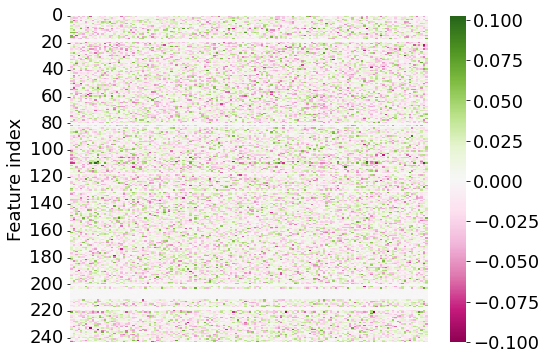

In [26]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight, cmap='PiYG')
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()

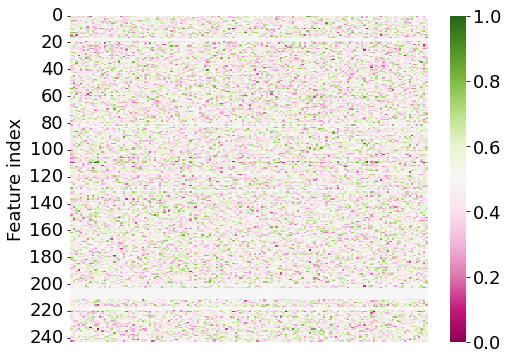

In [27]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()
first_layer_weight_scaled = (first_layer_weight - mn) / (mx - mn)

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight_scaled, cmap='PiYG', vmin=0, vmax=1)
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()